This notebook has been created to learn and revise the concepts taught in the fastai Deep Learning from Foundations course

https://course.fast.ai/part2

I will be very happy to receive suggestions to improve the explanations given in these notebooks.
It will be definitely improve my understanding of the material.


Let us pick the Fashion MNIST data for evaluating the deep learning model (Resnet) we are creating from scratch.

You can read about the Fashion MNIST data here https://github.com/zalandoresearch/fashion-mnist

# Import the packages

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
import os
import operator
import torch.nn.functional as F

# Create test functions

In [3]:
def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

### Create an equality test function

In [4]:
def test_eq(a,b): test(a,b,operator.eq,'==')

### Create a near function

In [5]:
def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a, b): test(a, b, near)

### Create a test near to zero function

In [6]:
def test_near_zero(a, tol=1e-3): assert a.abs() < tol, f"Near zero: {a}"

# Let's download the data

### Declaring all the source links

In [2]:
TRAIN_IMAGE_URL = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte'
TRAIN_LABEL_URL = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte'
TEST_IMAGE_URL = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte'
TEST_LABEL_URL = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte'

### Create a directory where we will download the files

In [7]:
download_dir = '/home/anubhavmaity/.fastai/data/fashion/'

In [8]:
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

### Download the training images

In [9]:
train_image_path = datasets.download_data(TRAIN_IMAGE_URL, Path(download_dir)/datasets.url2name(TRAIN_IMAGE_URL), ext='.gz'); train_image_path

NameError: name 'TRAIN_IMAGE_URL' is not defined

### Download the training labels

In [63]:
train_label_path = datasets.download_data(TRAIN_LABEL_URL, Path(download_dir)/datasets.url2name(TRAIN_LABEL_URL), ext='.gz'); train_label_path

PosixPath('/home/anubhavmaity/.fastai/data/fashion/train-labels-idx1-ubyte')

### Download the test images

In [64]:
test_image_path = datasets.download_data(TEST_IMAGE_URL, Path(download_dir)/datasets.url2name(TEST_IMAGE_URL), ext='.gz'); test_image_path

PosixPath('/home/anubhavmaity/.fastai/data/fashion/t10k-images-idx3-ubyte')

### Download the test labels

In [65]:
test_label_path = datasets.download_data(TEST_LABEL_URL, Path(download_dir)/datasets.url2name(TEST_LABEL_URL), ext='.gz'); test_label_path

PosixPath('/home/anubhavmaity/.fastai/data/fashion/t10k-labels-idx1-ubyte')

# Load the data

### Load the pickle files

In [8]:
# code snippet taken from https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [9]:
X_train, y_train = load_mnist(download_dir, kind='train')
X_valid, y_valid = load_mnist(download_dir, kind='t10k')

### Map the Numpy data to PyTorch Tensors

In [10]:
X_train,y_train,X_valid,y_valid = map(tensor, (X_train,y_train,X_valid,y_valid))

In [11]:
X_train, X_valid = X_train.float(), X_valid.float()

# Exploring the data 

In [12]:
n, c = X_train.shape; n, c

(60000, 784)

In [13]:
X_train, X_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([60000, 784]),
 tensor([9, 0, 0,  ..., 3, 0, 5], dtype=torch.uint8),
 torch.Size([60000]),
 tensor(0, dtype=torch.uint8),
 tensor(9, dtype=torch.uint8))

In [14]:
X_valid, X_valid.shape, y_valid, y_valid.shape, y_valid.min(), y_valid.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([10000, 784]),
 tensor([9, 2, 1,  ..., 8, 1, 5], dtype=torch.uint8),
 torch.Size([10000]),
 tensor(0, dtype=torch.uint8),
 tensor(9, dtype=torch.uint8))

In [15]:
assert n == y_train.shape[0] == 60000

In [16]:
test_eq(c,28*28)

In [17]:
test_eq(y_train.min(),0)
test_eq(y_train.max(),9)

In [18]:
img = X_train[0]

In [19]:
img.view(28,28).type()

'torch.FloatTensor'

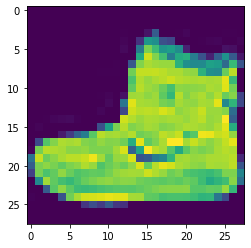

In [20]:
plt.imshow(img.view((28,28)));

### Let's introduce CMAP. 
For more info on CMAP refer https://stackoverflow.com/questions/25625952/matplotlib-what-is-the-function-of-cmap-in-imshow. 

CMAP input will be required to plot a grayscale version of the images when the images are missing the RGBA values.


In [21]:
mpl.rcParams['image.cmap'] = 'gray'

In [22]:
img.view(28,28).type()

'torch.FloatTensor'

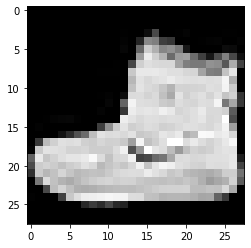

In [23]:
plt.imshow(img.view((28,28)));

### Plot image of each classes

##### TShirt / Top

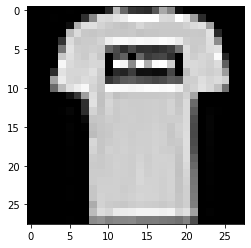

In [24]:
plt.imshow(X_train[y_train == 0][0].view(28, 28))

##### Trouser

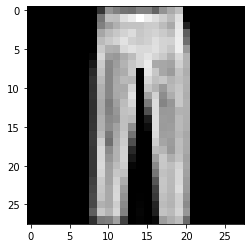

In [25]:
plt.imshow(X_train[y_train == 1][0].view(28, 28))

##### Pullover

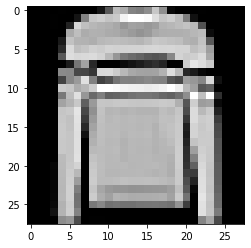

In [26]:
plt.imshow(X_train[y_train == 2][0].view(28, 28))

##### Dress

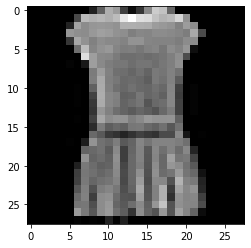

In [27]:
plt.imshow(X_train[y_train == 3][0].view(28, 28))

##### Coat

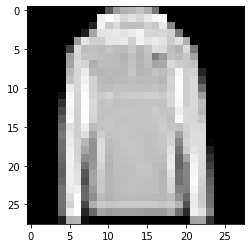

In [28]:
plt.imshow(X_train[y_train == 4][2].view(28, 28))

##### Sandal

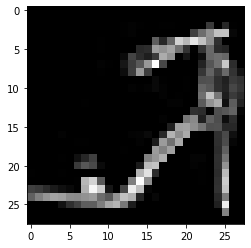

In [29]:
plt.imshow(X_train[y_train == 5][0].view(28, 28))

##### Shirt

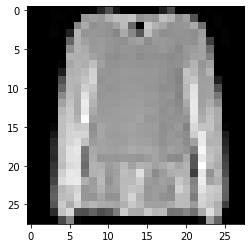

In [30]:
plt.imshow(X_train[y_train == 6][0].view(28, 28))

##### Sneaker

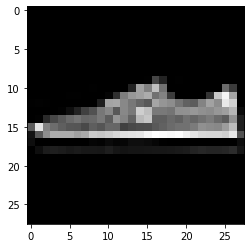

In [31]:
plt.imshow(X_train[y_train == 7][1].view(28, 28))

##### Bag

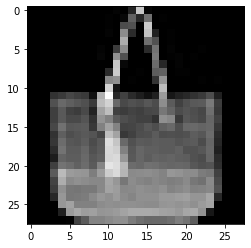

In [32]:
plt.imshow(X_train[y_train == 8][1].view(28, 28))

##### Ankle boot

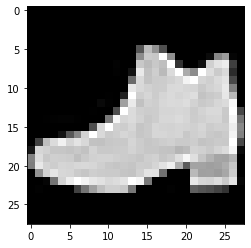

In [33]:
plt.imshow(X_train[y_train == 9][2].view(28, 28))

# Create a neural network model

### Define weight matrix

In [34]:
weights = torch.randn(784, 10)

### Define bias

In [35]:
bias = torch.zeros(10)

### Now we need a matrix multiplication function

In [36]:
def matmul(a, b):
    ar, ac = a.shape # no of rows and column of matrix a
    br, bc = b.shape # no of rows and column of matrix b
    assert ac == br  # check whether the matrix can be multiplied
    c = torch.zeros(ar, bc) # to store the resultant matrix after multiplying a and b, the size of c will be ar, bc
    
    # traverse over the rows of matrix a
    for i in range(ar):
        # traverse over the columns of matrix b
        for j in range(bc):
            # traverse over each element of row of matrix a and column of matrix b
            for k in range(ac):
                # multiply the elements and add it up
                c[i, j] += (a[i][k] * b[k][j])
    
    return c         

In [37]:
m1 = X_valid[:5]  # input, taking 5 rows of data as input
m2 = weights # weights

In [38]:
m1.shape, m2.shape # check the sizes of the input and weight

(torch.Size([5, 784]), torch.Size([784, 10]))

let's confirm the result of this function with the existing pytorch matmul function

In [39]:
t1 = m1@m2

In [40]:
test_near(t1, matmul(m1, m2))

In [41]:
%time t1 = matmul(m1, m2) # lets check the time taken

CPU times: user 801 ms, sys: 3.56 ms, total: 804 ms
Wall time: 803 ms


In [42]:
len(X_valid)

10000

For 5 rows of data, it is taking 1 sec. So, for 10k data it will take 2000 sec which is way too much. We need to optimize

In [43]:
t1.shape

torch.Size([5, 10])

### Reduce the matrix multiplication to two loops - Optimization 

Let's use the element wise operation to optimize the matrix multiplication

#### Review element wise operation

In [44]:
a = tensor([10, 1, -1])
b = tensor([4, 3, 2])
a, b

(tensor([10,  1, -1]), tensor([4, 3, 2]))

In [45]:
a * b

tensor([40,  3, -2])

In [46]:
a + b

tensor([14,  4,  1])

In [47]:
(a < b).float().mean()

tensor(0.6667)

Let's use element wise operation for Frobenius norm

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

In [48]:
m = tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]]).float(); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [49]:
m.shape

torch.Size([3, 3])

In [50]:
(m*m).sum().sqrt()

tensor(16.8819)

#### Introduce element wise multiplication in the matrix multiplication function

In [51]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i, j] = sum(a[i] * b[:,j]) 
    return c

let's confirm the result of this function with the existing pytorch matmul function

In [52]:
t1 = m1@m2

In [53]:
test_near(t1, matmul(m1, m2))

In [54]:
%timeit -n 10 _ = matmul(m1, m2)

185 ms ± 404 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


For 5 rows of data , it is taking 195 ms as compared to 1 sec before. Around 5 times improvement with the element wise multiplication. Let's optimize more

### Reduce the matrix multiplication to one loop - Optimization

#### Adding a unit axis to tensor

###### There are ways to prepend and append an unit axis to a tensor

In [55]:
c = tensor([1, 2, 3]); c.shape

torch.Size([3])

In [56]:
d = tensor([[1, 2, 3], [4, 5, 6]]); d.shape

torch.Size([2, 3])

###### Using None

In [57]:
c[None, :].shape

torch.Size([1, 3])

In [58]:
c[None].shape

torch.Size([1, 3])

In [59]:
c[:, None].shape

torch.Size([3, 1])

In [60]:
d[None, :].shape

torch.Size([1, 2, 3])

In [61]:
d[:, None].shape

torch.Size([2, 1, 3])

In [62]:
d[..., None].shape

torch.Size([2, 3, 1])

##### Using unsqueeze

In [63]:
c.unsqueeze(0).shape

torch.Size([1, 3])

In [64]:
c.unsqueeze(1).shape

torch.Size([3, 1])

In [65]:
d.unsqueeze(0).shape

torch.Size([1, 2, 3])

In [66]:
d.unsqueeze(1).shape

torch.Size([2, 1, 3])

In [67]:
d.unsqueeze(2).shape

torch.Size([2, 3, 1])

In [68]:
d.unsqueeze(-1).shape

torch.Size([2, 3, 1])

##### How to remove a unit axis? Use squeeze function

In [69]:
v = c.unsqueeze(0); v.shape

torch.Size([1, 3])

In [70]:
w = c.unsqueeze(1); w.shape

torch.Size([3, 1])

In [71]:
v.squeeze(0).shape

torch.Size([3])

In [72]:
w.squeeze(1).shape

torch.Size([3])

In [73]:
v = d.unsqueeze(0); v.shape

torch.Size([1, 2, 3])

In [74]:
v.squeeze(0).shape

torch.Size([2, 3])

In [75]:
w = d.unsqueeze(1); w.shape

torch.Size([2, 1, 3])

In [76]:
w.squeeze(1).shape

torch.Size([2, 3])

In [77]:
x = d.unsqueeze(-1); x.shape

torch.Size([2, 3, 1])

In [78]:
x.squeeze(-1).shape

torch.Size([2, 3])

#### Broadcasting with scalar

In [79]:
a = 1

In [80]:
c + a

tensor([2, 3, 4])

In [81]:
a + c

tensor([2, 3, 4])

In [82]:
a = -1

In [83]:
c * a

tensor([-1, -2, -3])

In [84]:
a * c

tensor([-1, -2, -3])

#### Broadcasting a vector to matrix

In [85]:
c

tensor([1, 2, 3])

In [86]:
d = tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]]); d

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [87]:
c.shape, d.shape

(torch.Size([3]), torch.Size([3, 3]))

In [88]:
c + d

tensor([[ 2,  4,  6],
        [ 5,  7,  9],
        [ 8, 10, 12]])

In [89]:
c[None].shape

torch.Size([1, 3])

In [90]:
c[None] + d

tensor([[ 2,  4,  6],
        [ 5,  7,  9],
        [ 8, 10, 12]])

In [91]:
c[:,None].shape

torch.Size([3, 1])

In [92]:
c[:, None] + d

tensor([[ 2,  3,  4],
        [ 6,  7,  8],
        [10, 11, 12]])

In [93]:
t1 = c.expand_as(d)

In [94]:
t1

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

In [95]:
t1.storage(), t1.stride(), t1.shape

( 1
  2
  3
 [torch.LongStorage of size 3], (0, 1), torch.Size([3, 3]))

In [96]:
t2 = c[:, None].expand_as(d)

In [97]:
t2

tensor([[1, 1, 1],
        [2, 2, 2],
        [3, 3, 3]])

In [98]:
t2.storage(), t2.stride(), t2.shape

( 1
  2
  3
 [torch.LongStorage of size 3], (1, 0), torch.Size([3, 3]))

#### Matrix multiplication with broadcasting

In [99]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    c = torch.zeros(ar, bc)
    assert ac == br
    for i in range(ar):
        # print(a[i, None].shape)
        # print(a[i].unsqueeze(-1).shape)
        c[i] = sum(a[i].unsqueeze(-1) * b)
    return c

In [100]:
test_near(m1@m2, matmul(m1, m2))

In [101]:
%timeit -n 10 _ = matmul(m1, m2)

19.5 ms ± 116 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


around 50 times and 10 times improvement compared to first and second version of matrix multiplication respectively

#### Using einsum 

In [102]:
def matmul(a, b):
    return torch.einsum('ik,kj->ij', a, b)

In [103]:
test_near(m1@m2, matmul(m1, m2))

In [104]:
%timeit -n 10 _ = matmul(m1, m2)

48.9 µs ± 10.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Around 2600 times improvement compared to the previous version using einsum

1,30,000 and 26000 times improvement compared to the 1st and 2nd version of matrix multiplication

### Forward and backward pass

In [105]:
train_mean, train_std = X_train.mean(), X_train.std()
train_mean, train_std

(tensor(72.9403), tensor(90.0212))

####  Normalize the images 

Why we need to normalize?

check out here 

https://stats.stackexchange.com/questions/211436/why-normalize-images-by-subtracting-datasets-image-mean-instead-of-the-current

In [106]:
def normalize(X, m, s):
    return (X-m)/s

In [107]:
X_train = normalize(X_train, train_mean, train_std)

In [108]:
X_train.mean(), X_train.std()

(tensor(-6.9172e-06), tensor(1.0000))

In [109]:
test_near_zero(X_train.mean())
test_near_zero(1 - X_train.std())

####  Normalize the validation set with training mean and standard deviation 

In [110]:
X_valid = normalize(X_valid, train_mean, train_std)

In [111]:
X_valid.mean(), X_valid.std()

(tensor(0.0023), tensor(0.9984))

#### Basic architecture - 1 hidden layer

In [112]:
n, m = X_train.shape
c = y_train.max() + 1
n, m, c

(60000, 784, tensor(10, dtype=torch.uint8))

In [113]:
nh = 50

In [114]:
w1 = torch.randn(m, nh)
b1 = torch.zeros(nh)
w2 = torch.randn(nh, 1)
b2 = torch.zeros(1)

In [115]:
w1.mean(), w1.std()

(tensor(0.0047), tensor(0.9953))

In [116]:
w2.mean(), w2.std()

(tensor(-0.0806), tensor(0.9838))

In [117]:
X_train.mean(), X_train.std()

(tensor(-6.9172e-06), tensor(1.0000))

In [118]:
def lin(x, w, b): return x@w + b

In [119]:
t = lin(X_train, w1, b1)

In [120]:
t.mean(), t.std()

(tensor(-1.6463), tensor(27.1711))

This is not good. We have mean of -1 and standard deviation of 27.

##### Let's use simplified kaiming initialization for the weights

In [121]:
w1 = torch.randn(m, nh)/math.sqrt(m)
b1 = torch.zeros(nh)
w2 = torch.randn(nh, 1)/math.sqrt(nh)
b2 = torch.zeros(1)

In [122]:
w1.mean(), w1.std()

(tensor(-0.0001), tensor(0.0356))

In [123]:
test_near_zero(w1.mean())
test_near_zero(w1.std()-1/math.sqrt(m))

In [124]:
t = lin(X_train, w1, b1)

In [125]:
t.mean(), t.std()

(tensor(0.0352), tensor(1.0293))

With simplified kaiming init we are getting a mean near to 0 and standard deviation of 1

##### Pass the linear output through relu

In [126]:
def relu(a): return a.clamp_min(0.)

In [127]:
t1 = relu(lin(X_train, w1, b1))
t1.mean(), t1.std()

(tensor(0.4191), tensor(0.6246))

the mean and standard deviation is not good after applying relu 

##### Improve it using kaiming init

$$\text{std} = \sqrt{\frac{2}{(1 + a^2) \times \text{fan_in}}}$$

a: the negative slope of the rectifier used after this layer (0 for ReLU by default)
fan_in: the row size of the weight matrix

This was introduced in the paper that described the Imagenet-winning approach from *He et al*: [Delving Deep into Rectifiers](https://arxiv.org/abs/1502.01852), which was also the first paper that claimed "super-human performance" on Imagenet (and, most importantly, it introduced resnets!)

In [128]:
w1 = torch.randn(m, nh) * math.sqrt(2/m)
b1 = torch.zeros(nh)

In [129]:
test_near_zero(w1.mean())
test_near_zero(w1.std() - math.sqrt(2/m))

In [130]:
t = relu(lin(X_train, w1, b1))

In [131]:
t.mean(), t.std()

(tensor(0.5580), tensor(0.8279))

The standard deviation looks fine. How can we improve the mean?

In [132]:
def relu(a):
    return a.clamp_min(0.) - 0.5

In [133]:
t = relu(lin(X_train, w1, b1))

In [134]:
t.mean(), t.std()

(tensor(0.0580), tensor(0.8279))

It improved!

Plot the new version of relu

In [135]:
x = tensor(list(range(-2,2))).float()
y = relu(x)

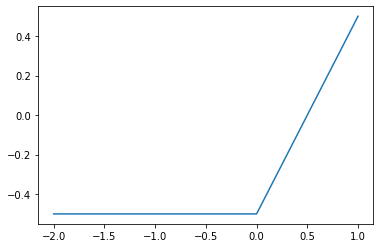

In [136]:
plt.plot(x, y)

##### Check the torch init function

In [137]:
from torch.nn import init

In [138]:
w1 = torch.zeros(m, nh)
init.kaiming_normal_(w1, mode='fan_out')
t = relu(lin(X_train, w1, b1))

In [139]:
w1.mean(), w1.std()

(tensor(-0.0003), tensor(0.0505))

In [140]:
test_near_zero(w1.mean())
test_near_zero(w1.std() - math.sqrt(2/m))

In [141]:
t.mean(), t.std()

(tensor(0.0547), tensor(0.8676))

In [142]:
init.kaiming_normal_??

Why fan_out in init.kaiming_normal_(w1, mode='fan_out')?

In [143]:
# because when initializing, the shape of w1 is 
w1.shape

torch.Size([784, 50])

this is transpose of the 50 by 784 matrix. <br/> 
So, if we would have given 'fan_in', the weight would have been multiplied by sqrt(2/784) which we dont want. <br/>
Therefore we have mentioned 'fan_out' to get the initiliazed weight matrix multiplied by sqrt(2/50`)

Ok. So, Is pyTorch taking the transpose of the matrix when multiplying? <br/>
Yes it is. <br/>
In pyTorch the matrix is initialized with the shape 784, 50 during the forward pass


In [144]:
torch.nn.Linear.forward??

In [145]:
torch.nn.functional.linear??

In [146]:
torch.nn.Conv2d??

In [147]:
torch.nn.modules.conv._ConvNd.reset_parameters??

In [148]:
def model(xb):
    l1 = lin(xb, w1, b1)
    l2 = relu(l1)
    l3 = lin(l2, w2, b2)
    return l3

In [149]:
%timeit -n 10 _=model(X_valid)

3.45 ms ± 765 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [150]:
assert model(X_valid).shape==torch.Size([X_valid.shape[0],1])

##### Loss Function: MSE

In [151]:
model(X_valid).shape

torch.Size([10000, 1])

In [152]:
y_train.shape

torch.Size([60000])

In [153]:
# using mse to keep things simpler, we will soon use cross entropy loss
def mse(output, targ): return (output.squeeze(-1) - targ).pow(2).mean()

In [154]:
y_train, y_valid = y_train.float(), y_valid.float()

In [155]:
preds = model(X_train)

In [156]:
preds.shape, y_train.shape

(torch.Size([60000, 1]), torch.Size([60000]))

In [157]:
mse(preds, y_train)

tensor(21.7873)

##### Gradients and backward pass

Backward pass follows the chain rule. <br/>
So, the order of the functions for chain rule will be:<br/>
1. Loss function
2. Relu function
3. Matrix multiplication function

Let's introduce the gradients of these functions

In [158]:
# lets declare the weights and biases again
w1 = torch.randn(m, nh) * math.sqrt(2/m)
b1 = torch.zeros(nh)
w2 = torch.randn(nh, 1) * math.sqrt(2/nh)
b2 = torch.zeros(1)

In [159]:
# derivative of the loss function
# For the derivation you can refer to https://forums.fast.ai/t/lesson-8-2019-discussion-wiki/41323/623 (posted by Aman Arora)
def mse_grad(inp, targ):
    # gradient of loss with respect to input of previous layer
    inp.g = 2. * (inp.squeeze() - targ).unsqueeze(-1) / inp.shape[0]

In [160]:
def relu_grad(inp, out):
    # gradient of relu with respect to input activations
    inp.g = (inp > 0).float() * out.g

In [161]:
def lin_grad(inp, out, w, b):
    # gradient of matmul with respect to input
    inp.g = out.g @ w.t()
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    b.g = out.g.sum(0)

In [162]:
def forward_and_backward(inp, targ):
    l1 = inp @ w1 + b1
    l2 = relu(l1)
    out = l2 @ w2 + b2
    
    loss = mse(out, targ) # we dont need the loss backward
    print(loss)
    
    mse_grad(out, targ)
    lin_grad(l2, out, w2, b2)
    relu_grad(l1, l2)
    lin_grad(inp, l1, w1, b1)

In [163]:
forward_and_backward(X_train, y_train)

tensor(28.0202)


In [164]:
w1g = w1.g.clone()
w2g = w2.g.clone()
b1g = b1.g.clone()
b2g = b2.g.clone()
ig = X_train.g.clone()

Lets compare the results with pytorch autograd

In [165]:
xt2 = X_train.clone().requires_grad_(True)
w12 = w1.clone().requires_grad_(True)
w22 = w2.clone().requires_grad_(True)
b12 = b1.clone().requires_grad_(True)
b22 = b2.clone().requires_grad_(True)

In [166]:
# checking if parameters is cloned perfectly
test_near(w1, w12)
test_near(w2, w22)
test_near(b1, b12)
test_near(b2, b22)
test_near(X_train, xt2)

In [167]:
def forward(inp, targ):
    l1 = inp @ w12 + b12
    l2 = relu(l1)
    out = l2 @ w22 + b22
    return mse(out, targ) # we don't need the loss in backward

In [168]:
loss = forward(xt2, y_train)
print(loss)

tensor(28.0202, grad_fn=<MeanBackward0>)


In [169]:
loss.backward()

In [170]:
test_near(w22.grad, w2g)
test_near(b22.grad, b2g)
test_near(w12.grad, w1g)
test_near(b12.grad, b1g)
test_near(xt2.grad, ig)

##### Refactor the model

Make the layers as classes

In [171]:
class Relu():
    def __call__(self, inp):
        self.inp = inp
        self.out = inp.clamp_min(0.) - 0.5
        return self.out
    
    def backward(self): self.inp.g = (self.inp > 0).float() * self.out.g

In [172]:
class Lin():
    def __init__(self, w, b): self.w, self.b = w, b
    
    def __call__(self, inp):
        self.inp = inp
        self.out = inp @ self.w + self.b
        return self.out
    
    def backward(self):
        self.inp.g = self.out.g @ self.w.t()
        # Creating a giant outer product, just to sum it, is inefficient!
        self.w.g = (self.inp.unsqueeze(-1) * self.out.g.unsqueeze(1)).sum(0)
        self.b.g = self.out.g.sum(0)

In [173]:
class Mse():
    def __call__(self, inp, targ):
        self.inp = inp
        self.targ = targ
        self.out = (inp.squeeze() - targ).pow(2).mean()
        return self.out
    
    def backward(self):
        self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.inp.shape[0] 

In [174]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1, b1), Relu(), Lin(w2, b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [175]:
w1.g, b1.g, w2.g, b2.g = [None] * 4
model = Model(w1, b1, w2, b2)

In [176]:
%time loss = model(X_train, y_train)

CPU times: user 119 ms, sys: 8.9 ms, total: 127 ms
Wall time: 21.3 ms


In [177]:
%time model.backward()

CPU times: user 3.15 s, sys: 2.2 s, total: 5.36 s
Wall time: 899 ms


In [178]:
test_near(w2g, w2.g)
test_near(w1g, w1.g)
test_near(b2g, b2.g)
test_near(b1g, b1.g)
test_near(ig, X_train.g)

##### Refactor again - Remove the duplicate codes in inits 

In [179]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def forward(self): raise Exception('Not implemented')
    def backward(self): self.bwd(self.out, *self.args)

In [180]:
class Relu(Module):
    def forward(self, inp): return inp.clamp_min(0.) - 0.5
    def bwd(self, out, inp): inp.g = (inp > 0).float() * out.g 

In [181]:
class Lin(Module):
    def __init__(self, w, b): self.w, self.b = w, b
    def forward(self, inp): return inp@self.w + self.b
    def bwd(self, out, inp): 
        inp.g = out.g @ self.w.t()
        self.w.g = torch.einsum('bi,bj->ij', inp, out.g) #used einsum for faster computation
        self.b.g = out.g.sum(0)

In [182]:
class Mse(Module):
    def forward(self, inp, targ): return (inp.squeeze() - targ).pow(2).mean()
    def bwd(self, out, inp, targ): inp.g = 2. * (inp.squeeze() - targ).unsqueeze(-1) / inp.shape[0]

In [183]:
class Model():
    def __init__(self):
        self.layers = [Lin(w1, b1), Relu(), Lin(w2, b2)]
        self.loss = Mse()
    
    def __call__(self, x, targ):
        for l in self.layers: 
            x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [184]:
w1.g, b1.g, w2.g, b2.g = [None] * 4
model = Model()

In [185]:
%time loss = model(X_train, y_train)

CPU times: user 123 ms, sys: 6.88 ms, total: 130 ms
Wall time: 21.8 ms


In [186]:
loss

tensor(28.0202)

In [187]:
%time model.backward()

CPU times: user 244 ms, sys: 72.9 ms, total: 316 ms
Wall time: 53.1 ms


In [188]:
test_near(w1g, w1.g)
test_near(w2g, w2.g)
test_near(b1g, b1.g)
test_near(b2g, b2.g)
test_near(ig, X_train.g)

##### Without einsum

In [189]:
class Lin(Module):
    def __init__(self, w, b): self.w, self.b = w, b
    def forward(self, inp): return inp@self.w + self.b
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = inp.t() @ out.g
        self.b.g = out.g.sum(0)

In [190]:
w1.g, b1.g, w2.g, b2.g = [None] * 4

In [191]:
model = Model()

In [192]:
%time loss = model(X_train, y_train)

CPU times: user 109 ms, sys: 12.2 ms, total: 122 ms
Wall time: 20.3 ms


In [193]:
%time model.backward()

CPU times: user 261 ms, sys: 48.1 ms, total: 309 ms
Wall time: 51.8 ms


In [194]:
test_near(w2g, w2.g)
test_near(b2g, b2.g)
test_near(w1g, w1.g)
test_near(b1g, b1.g)
test_near(ig, X_train.g)

##### Using PyTorch - nn.Module and nn.Linear

In [195]:
from torch import nn

In [196]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        self.loss = mse
    
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return x, self.loss(x.squeeze(), targ)

In [197]:
model = Model(m, nh, 1)

In [198]:
%time pred, loss = model(X_train, y_train)

CPU times: user 152 ms, sys: 61.6 ms, total: 213 ms
Wall time: 48.5 ms


In [199]:
%time loss.backward()

CPU times: user 251 ms, sys: 117 ms, total: 368 ms
Wall time: 61.4 ms


##### Let's use the cross entropy loss

$$ -\sum x\, \log p(x) $$

We need to have 10 predictions from the last layer as there are 10 classes <br/>
So lets create a new model with 10 outputs and remove the loss utility from it

In [200]:
y_train, y_valid = y_train.long(), y_valid.long()

In [243]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
    
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [244]:
model = Model(m, nh, 10)

In [245]:
pred = model(X_train)

In [246]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1, keepdim=True))).log()

In [247]:
pred.shape

torch.Size([60000, 10])

In [206]:
sm_pred = log_softmax(pred)

In [207]:
y_train[:3]

tensor([9, 0, 0])

In [208]:
sm_pred[[0, 1, 2], [9, 0, 0]]

tensor([-2.3688, -2.4082, -2.1942], grad_fn=<IndexBackward>)

In [209]:
y_train.shape

torch.Size([60000])

In [210]:
def nll(inputp, target): return -inputp[range(target.shape[0]), target].mean()

In [211]:
loss = nll(sm_pred, y_train.long())

In [212]:
loss

tensor(2.3742, grad_fn=<NegBackward>)

We can simplify the log softmax function

In [213]:
def log_softmax(x): return x - x.exp().sum(-1, keepdim=True).log()

In [214]:
test_near(nll(log_softmax(pred), y_train), loss)

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [215]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:, None]).exp().sum(-1).log()

In [216]:
test_near(logsumexp(pred), pred.logsumexp(-1))

In [217]:
def log_softmax(x): return x - x.logsumexp(-1, keepdim=True)

In [218]:
test_near(nll(log_softmax(pred), y_train), loss)

In [219]:
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

We have the cross entropy loss to replace the nll loss and log softmax

In [220]:
test_near(F.cross_entropy(pred, y_train), loss)

### Training Loop

In [221]:
loss_func = F.cross_entropy

Lets check the accuracy of the above model that we created 

In [222]:
# defining the accuracy function
def accuracy(out, yb): return (torch.argmax(out, dim=1) == yb).float().mean()

In [223]:
# batch size
bs = 64

xb = X_train[:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([-0.0268,  0.4925, -0.1419, -0.0099, -0.5406,  0.3221,  0.3226, -0.0347,
         -0.2517, -0.0136], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [224]:
yb = y_train[:bs]
loss_func(preds, yb)

tensor(2.3442, grad_fn=<NllLossBackward>)

In [225]:
accuracy(preds, yb)

tensor(0.1250)

The accuracy is too less. 

let's introduce a training loop

In [248]:
lr = 0.5 # learning rate
epochs = 1 # no of epoch

In [249]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i + bs
        xb = X_train[start_i: end_i]
        yb = y_train[start_i: end_i]
        loss = loss_func(model(xb), yb)
        
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'): 
                    # the linear layer has the weight attribute, 
                    # you can check the class source code
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()                    

let's check the accuracy and the loss again

In [250]:
loss_func(model(X_train), y_train), accuracy(model(X_train), y_train)

(tensor(0.8340, grad_fn=<NllLossBackward>), tensor(0.7174))

##### Refactor the parameter update code

We have to set the layers in the Model class

In [231]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
    
    def __call__(self, x):
        return self.l2(F.relu(self.l1(x)))

In [232]:
model = Model(m , nh, 10)

In [236]:
for name, l in model.named_children(): print(f"{name}:{l}")

l1:Linear(in_features=784, out_features=50, bias=True)
l2:Linear(in_features=50, out_features=10, bias=True)


In [237]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [238]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [239]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i  = start_i + bs
            xb = X_train[start_i: end_i]
            yb = y_train[start_i: end_i]
            loss = loss_func(model(xb), yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= lr*p.grad
                model.zero_grad()

In [241]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.4764, grad_fn=<NllLossBackward>), tensor(0.8125))

Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

In [251]:
??nn.Module

In [253]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
    
    def __setattr__(self, k, v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k, v)
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [256]:
mdl = DummyModule(m, nh, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [257]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

##### Using the original layers approach - Registering the modules